# [Source](https://langchain-ai.github.io/langgraph/tutorials/get-started/5-customize-state/)

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
from langchain_ollama import ChatOllama
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition, create_react_agent
from langgraph.checkpoint.memory import InMemorySaver
from langchain_tavily import TavilySearch

In [2]:
llm = ChatOllama(
    model=os.getenv("ollama_model"),
    reasoning=True,
)

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    author: str
    release_date: str

In [4]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.types import Command, interrupt

In [5]:
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
@tool
def human_assistance(
    author: str, release_date: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "author": author,
            "release_date": release_date,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_author = author
        verified_release_date = release_date
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_author = human_response.get("author", author)
        verified_release_date = human_response.get("release_date", release_date)
        response = f"No. The correct information is: {human_response}. You can stop searching now."

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "author": verified_author,
        "release_date": verified_release_date,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [6]:
tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)
# agent = create_react_agent(
#     model=llm,
#     tools=tools,
#     prompt="Reasoning: high"
# )

In [7]:
def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # print(message)
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

In [8]:
graph_builder = StateGraph(State)

In [9]:
graph_builder.add_node("chatbot", chatbot)

In [10]:
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [11]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

In [12]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [13]:
memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [14]:
from IPython.display import Image, display

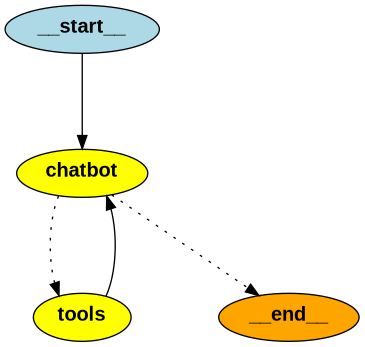

In [15]:
g = graph.get_graph()
png = g.draw_png()     # pygraphviz + graphviz 필요
display(Image(png))

In [16]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (dc551695-003a-41fb-9e3a-c8210dd61354)
 Call ID: dc551695-003a-41fb-9e3a-c8210dd61354
  Args:
    query: LangGraph release date
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph release date", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://blog.langchain.com/langgraph-studio-the-first-agent-ide/", "title": "LangGraph Studio: The first agent IDE - LangChain Blog", "content": "In January 2023, we launched LangGraph, a highly controllable, low-level orchestration framework for building agentic applications. Since then, we've seen teams build more compl

In [17]:
human_command = Command(
    resume={
        "author": "LangGraph",
        "release_date": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (dc459f58-7fee-4ac2-9c61-585620f858af)
 Call ID: dc459f58-7fee-4ac2-9c61-585620f858af
  Args:
    author: LangGraph Release Info
    release_date: 2023-01
================================= Tool Message =================================
Name: human_assistance

No. The correct information is: {'author': 'LangGraph', 'release_date': 'Jan 17, 2024'}. You can stop searching now.
================================== Ai Message ==================================
Tool Calls:
  human_assistance (f519da87-4fec-4a91-a4ee-45dd2b805bbd)
 Call ID: f519da87-4fec-4a91-a4ee-45dd2b805bbd
  Args:
    author: LangGraph
    release_date: Jan 17, 2024


In [18]:
human_command = Command(
    resume={
        "author": "LangGraph",
        "release_date": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (f519da87-4fec-4a91-a4ee-45dd2b805bbd)
 Call ID: f519da87-4fec-4a91-a4ee-45dd2b805bbd
  Args:
    author: LangGraph
    release_date: Jan 17, 2024
================================= Tool Message =================================
Name: human_assistance

No. The correct information is: {'author': 'LangGraph', 'release_date': 'Jan 17, 2024'}. You can stop searching now.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (cf9bb1dc-e2f3-4ad9-97ce-410682ad437f)
 Call ID: cf9bb1dc-e2f3-4ad9-97ce-410682ad437f
  Args:
    query: Jan 17 2024 LangGraph release
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "Jan 17 2024 LangGraph release", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://changelog.langc

In [19]:
human_command = Command(
    resume={
        "author": "LangGraph",
        "release_date": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (b2d380b2-2a84-4b2b-baad-7ab20f38843c)
 Call ID: b2d380b2-2a84-4b2b-baad-7ab20f38843c
  Args:
    author: LangGraph
    release_date: Jan 17, 2024
================================= Tool Message =================================
Name: human_assistance

No. The correct information is: {'author': 'LangGraph', 'release_date': 'Jan 17, 2024'}. You can stop searching now.
================================== Ai Message ==================================

LangGraph was first released on **January 17, 2024**.  

*(Confirmed via the human‑assistance review.)*


In [20]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("author", "release_date")}

{'author': 'LangGraph', 'release_date': 'Jan 17, 2024'}

In [21]:
graph.update_state(config, {"author": "LangGraph (library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09c29f-74a2-63ac-8012-08c0932b5769'}}

In [22]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("author", "release_date")}

{'author': 'LangGraph (library)', 'release_date': 'Jan 17, 2024'}